# Data Cleaning

In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [2]:
#import csv file
startup_data = pd.read_csv('ks-projects-201801.csv')
startup_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
print("Data type : ", type(startup_data))
print("Data dims : ", startup_data.shape)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (378661, 15)


In [4]:
startup_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [5]:
pd.unique(startup_data.state)

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

In [6]:
startup_data.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [7]:
startup_data.drop(columns=['name','ID','category','usd pledged','currency','goal','pledged'], axis = 1, inplace = True)

In [8]:
startup_data = startup_data[startup_data['state'].isin(['failed', 'successful'])]
startup_data.sample(10)

,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
92219,Design,2015-04-24,2015-04-17 19:01:31,successful,47,US,1723.00,1400.00
97634,Publishing,2013-09-21,2013-08-22 07:44:22,successful,18,US,8568.00,8448.00
175791,Music,2017-02-06,2017-01-16 02:04:33,failed,0,CA,0.00,1141.64
275843,Film & Video,2017-01-23,2016-12-09 08:00:03,failed,1,US,1.00,300.00
98906,Food,2012-03-13,2012-01-28 06:55:36,failed,23,US,713.34,5000.00
119783,Design,2016-04-30,2016-03-01 16:11:45,failed,8,US,60.00,10000.00
361870,Art,2017-12-15,2017-11-12 18:22:58,successful,80,US,8610.00,6000.00
350169,Games,2016-06-18,2016-05-18 06:00:26,failed,105,US,9735.00,25000.00
336543,Fashion,2016-10-13,2016-09-13 12:02:08,successful,93,US,10539.00,10000.00
210758,Publishing,2013-01-28,2012-11-29 04:25:42,failed,6,US,56.00,20000.00


1. Here, we can see the various types of status of the startups but we are concerned  only with successful and failed startups as we are predicting this category.
2. Thus we remove all other categories such as 'canceled', 'live', 'undefined', 'suspended'  and only keep the remaining two.
3. We examine the null values and see that columns 'name' and 'usd pledged' have null values but we do not need to correct this as these columns are unnecessary in our problem so we will ultimately drop them.
4. We remove all unnecesary columns that are not going to help predict the success of the startup such as 'id', 'name' etc.


In [9]:
startup_data = startup_data.assign(state_num = (startup_data['state'] == 'successful').astype(int))
#startup_data.drop(columns=['state'], axis = 1, inplace = True)
startup_data

,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,state_num
0,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,0
1,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,0
2,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,0
3,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,0
5,Food,2016-04-01,2016-02-26 13:38:27,successful,224,US,52375.0,50000.00,1
...,...,...,...,...,...,...,...,...,...
378654,Food,2017-04-19,2017-03-20 22:08:22,failed,4,US,154.0,6500.00,0
378657,Film & Video,2011-07-19,2011-06-22 03:35:14,failed,5,US,155.0,1500.00,0
378658,Film & Video,2010-08-16,2010-07-01 19:40:30,failed,1,US,20.0,15000.00,0
378659,Technology,2016-02-13,2016-01-13 18:13:53,failed,6,US,200.0,15000.00,0


In [10]:

country_encoder = LabelEncoder()
main_category_encoder = LabelEncoder()

startup_data['encoded_country'] = country_encoder.fit_transform(startup_data['country'])
startup_data['encoded_main_category'] = main_category_encoder.fit_transform(startup_data['main_category'])

startup_data

,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,state_num,encoded_country,encoded_main_category
0,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,0,9,12
1,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,0,22,6
2,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,0,22,6
3,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,0,22,10
5,Food,2016-04-01,2016-02-26 13:38:27,successful,224,US,52375.0,50000.00,1,22,7
...,...,...,...,...,...,...,...,...,...,...,...
378654,Food,2017-04-19,2017-03-20 22:08:22,failed,4,US,154.0,6500.00,0,22,7
378657,Film & Video,2011-07-19,2011-06-22 03:35:14,failed,5,US,155.0,1500.00,0,22,6
378658,Film & Video,2010-08-16,2010-07-01 19:40:30,failed,1,US,20.0,15000.00,0,22,6
378659,Technology,2016-02-13,2016-01-13 18:13:53,failed,6,US,200.0,15000.00,0,22,13


In [11]:
startup_data.deadline = pd.to_datetime(startup_data.deadline)
startup_data.launched = pd.to_datetime(startup_data.launched)
startup_data

,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,state_num,encoded_country,encoded_main_category
0,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,0,9,12
1,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,0,22,6
2,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,0,22,6
3,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,0,22,10
5,Food,2016-04-01,2016-02-26 13:38:27,successful,224,US,52375.0,50000.00,1,22,7
...,...,...,...,...,...,...,...,...,...,...,...
378654,Food,2017-04-19,2017-03-20 22:08:22,failed,4,US,154.0,6500.00,0,22,7
378657,Film & Video,2011-07-19,2011-06-22 03:35:14,failed,5,US,155.0,1500.00,0,22,6
378658,Film & Video,2010-08-16,2010-07-01 19:40:30,failed,1,US,20.0,15000.00,0,22,6
378659,Technology,2016-02-13,2016-01-13 18:13:53,failed,6,US,200.0,15000.00,0,22,13


In [12]:
startup_data['Duration_of_campaign(days)'] = (startup_data['deadline'] - startup_data.launched).dt.days 

startup_data['Deadline(y)']=pd.to_datetime(startup_data.deadline).dt.year 
startup_data['Launched(y)']=pd.to_datetime(startup_data.launched).dt.year 

startup_data['Launched(m)']=pd.to_datetime(startup_data.launched).dt.month
startup_data['Deadline(m)']=pd.to_datetime(startup_data.deadline).dt.month 
startup_data.drop(columns=['deadline','launched'], axis = 1, inplace = True)
startup_data

,main_category,state,backers,country,usd_pledged_real,usd_goal_real,state_num,encoded_country,encoded_main_category,Duration_of_campaign(days),Deadline(y),Launched(y),Launched(m),Deadline(m)
0,Publishing,failed,0,GB,0.0,1533.95,0,9,12,58,2015,2015,8,10
1,Film & Video,failed,15,US,2421.0,30000.00,0,22,6,59,2017,2017,9,11
2,Film & Video,failed,3,US,220.0,45000.00,0,22,6,44,2013,2013,1,2
3,Music,failed,1,US,1.0,5000.00,0,22,10,29,2012,2012,3,4
5,Food,successful,224,US,52375.0,50000.00,1,22,7,34,2016,2016,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,Food,failed,4,US,154.0,6500.00,0,22,7,29,2017,2017,3,4
378657,Film & Video,failed,5,US,155.0,1500.00,0,22,6,26,2011,2011,6,7
378658,Film & Video,failed,1,US,20.0,15000.00,0,22,6,45,2010,2010,7,8
378659,Technology,failed,6,US,200.0,15000.00,0,22,13,30,2016,2016,1,2


1. As 'state' is a categorical variable, we need to convert this into numerical by assigning 'successful' as 1 and 'failed' as 0 in a new column named 'state_num'. We then drop the original state column.
2. We then use LabelEncoder function from scikit-learn to encode categorical columns in the DataFrame startup_data. Then, it initializes LabelEncoder objects for each categorical column and fits them to the respective columns. After fitting, it transforms the columns into encoded numerical values. Finally, it adds new columns to the DataFrame (encoded_country and encoded_main_category) to store the encoded data, leaving the original columns (country and main_category) intact.
3. Then we convert the deadline and launched columns in the startup_data DataFrame to datetime objects, enabling easier manipulation and analysis of date and time data using to_datetime functions
4. We then calculate the duration of the campaign by subtracting the deadline and launched dates for easy manipulations and analysis.
5. We also convert the datetime variables into seperate variables of Deadline(y),Launched(y),Launched(m),Deadline(m) which show the respective years and months of the data, and then we drop the original deadline and launched columns.






# EDA

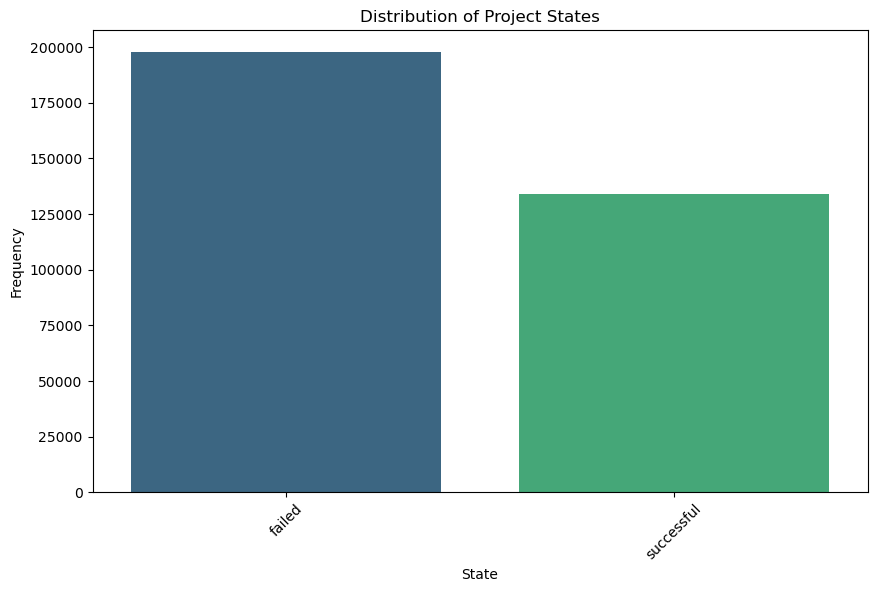

In [13]:
state_counts = startup_data['state'].value_counts()

plt.figure(figsize=(10, 6))
sb.barplot(x=state_counts.index, y=state_counts.values, palette='viridis')
plt.title('Distribution of Project States')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.show()

# Basic Exploratory Data Analysis

We came up with some hypotheses regarding some factors that might affect whether a kickstarter project will be successful. We will explore the statistics regarding these factors to test our hypothesis

Fixed Factors: Factors that are determined from the beginning
1) The lower the goal amount, the easier it is to acheive it and be successful.
2) The longer the 'fundraising' duration, the more likely it is to succeed.
3) Certain categories are more likely to succeed than others.
4) Certain countries might affect success of project.

Variable Factors: Factors that you will only find out at the end of the campaign
1) Backers
2) Real Pledged Amount

When we initially plotted a box plot for state vs numerical values, we realise there were a lot of outliers. So we removed the outliers for each factor.

We do this by finding absolute z-score which indicates the standard deviation of each data from the mean and then filtering data with more than z-score of 3 which are considered outliers.

In [14]:
startup_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 331675 entries, 0 to 378660
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   main_category               331675 non-null  object 
 1   state                       331675 non-null  object 
 2   backers                     331675 non-null  int64  
 3   country                     331675 non-null  object 
 4   usd_pledged_real            331675 non-null  float64
 5   usd_goal_real               331675 non-null  float64
 6   state_num                   331675 non-null  int32  
 7   encoded_country             331675 non-null  int32  
 8   encoded_main_category       331675 non-null  int32  
 9   Duration_of_campaign(days)  331675 non-null  int64  
 10  Deadline(y)                 331675 non-null  int32  
 11  Launched(y)                 331675 non-null  int32  
 12  Launched(m)                 331675 non-null  int32  
 13  Deadline(m)        

# Data Analysis 1: Goal Amount(Numerical)

We cloned the data to focus on hypothesis 1, goal amount vs state

In [15]:
goal_amount = startup_data

In [16]:
#Removing Outliers
z_goal = np.abs(stats.zscore(goal_amount['usd_goal_real']))
threshold = 3
outliers_goal = goal_amount[z_goal > threshold]
goal_amount = goal_amount.drop(outliers_goal.index)

<Axes: xlabel='usd_goal_real', ylabel='state'>

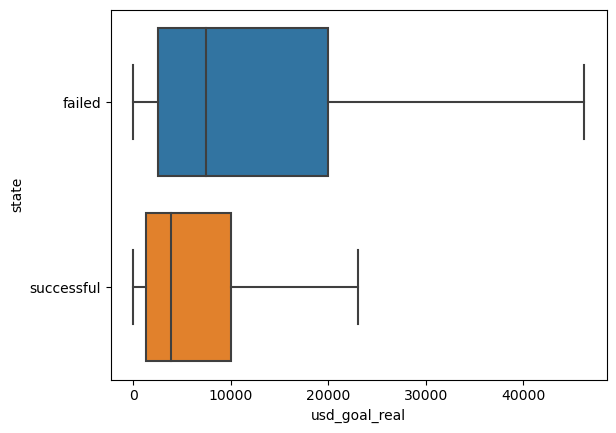

In [17]:
#In the following code, we plottted the box plot for goal amount vs state
sb.boxplot(data=goal_amount, x="usd_goal_real", y="state", showfliers = False)

In [18]:
print("Mean Goal Amounts:")
print(goal_amount.groupby('state')['usd_goal_real'].mean())

print("\nMedian Goal Amounts:")
print(goal_amount.groupby('state')['usd_goal_real'].median())


Mean Goal Amounts:
state
failed        30235.153082
successful     9532.853357
Name: usd_goal_real, dtype: float64

Median Goal Amounts:
state
failed        7500.00
successful    3837.74
Name: usd_goal_real, dtype: float64


Successful projects tend to have a significantly lower goal amounts on average compared to failed projects. The median values (less affected by outliers) highlights this point, showing that a typical successful project has a goal of about half or less than half of a failed project. <br>
Lets further examine the relationship

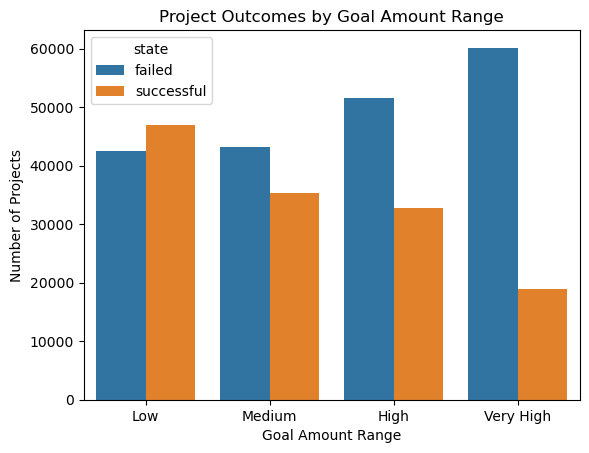

In [19]:
goal_amount['goal_range'] = pd.qcut(goal_amount['usd_goal_real'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

sb.countplot(data=goal_amount, x='goal_range', hue='state')
plt.xlabel('Goal Amount Range')
plt.ylabel('Number of Projects')
plt.title('Project Outcomes by Goal Amount Range')
plt.show()


There is a certain relationship where there is a higher number of failure when the goal amount is higher, and there is a higher amount of success when the goal amount is lower. <br>
Lets take a closer look at the success rate of the project by their goal amount range

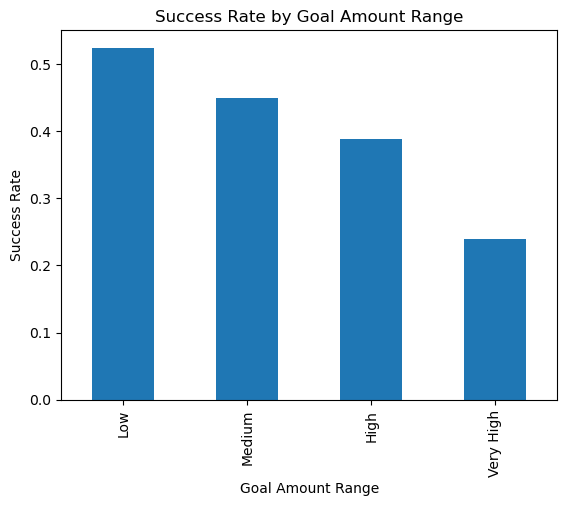

In [20]:
# Calculate success rate
success_rate = goal_amount.pivot_table(index='goal_range', columns='state', aggfunc='size', fill_value=0)
success_rate['success_rate'] = success_rate['successful'] / (success_rate['successful'] + success_rate['failed'])

# Plot
success_rate['success_rate'].plot(kind='bar')
plt.xlabel('Goal Amount Range')
plt.ylabel('Success Rate')
plt.title('Success Rate by Goal Amount Range')
plt.show()


From evidence, we could possibly conclude that the success of a kickstarter project could highly depend on the goal amonut, where if the goal is lower, the success rate tends to be higher.

# Data Analysis 2: Duration(Numerical)

We cloned the data to focus on hypothesis 2, duration vs state

In [21]:
duration = startup_data

In [22]:
#Removing Outliers
z_duration = np.abs(stats.zscore(duration['Duration_of_campaign(days)']))
threshold = 3
outliers_duration = duration[z_duration > threshold]
duration = duration.drop(outliers_duration.index)

<Axes: xlabel='Duration_of_campaign(days)', ylabel='state'>

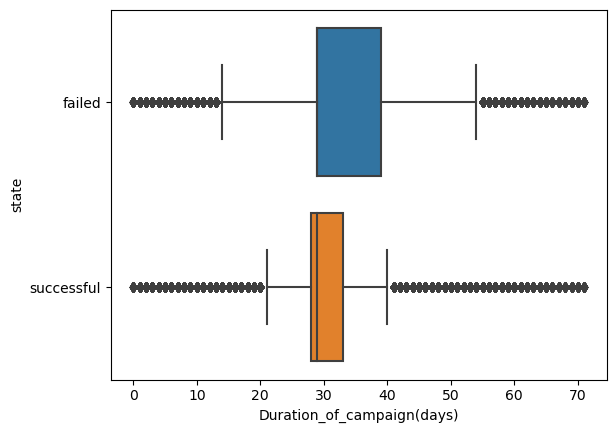

In [23]:
#In the following code, we plottted the box plot for duration vs state
sb.boxplot(data=duration, x="Duration_of_campaign(days)", y="state", showfliers = True)

In [24]:
print("Mean Goal Amounts:")
print(duration.groupby('state')['Duration_of_campaign(days)'].mean())

print("\nMedian Goal Amounts:")
print(duration.groupby('state')['Duration_of_campaign(days)'].median())

Mean Goal Amounts:
state
failed        33.641704
successful    30.717900
Name: Duration_of_campaign(days), dtype: float64

Median Goal Amounts:
state
failed        29.0
successful    29.0
Name: Duration_of_campaign(days), dtype: float64


Projects that failed has an average duration of about 34 days and projects that are successful have about 31 days. This suggests that projects that are within a months time are usually more successful. In fact, Kickstarter website states that there is a 60days limit to the campaigns, and they have found that projects lasting any longer than 60 days are rarely successful. They also recommend to set the duration to run for 30 days or less.<br><br>
we have to, however, keep in mind that there is a lot of outliers

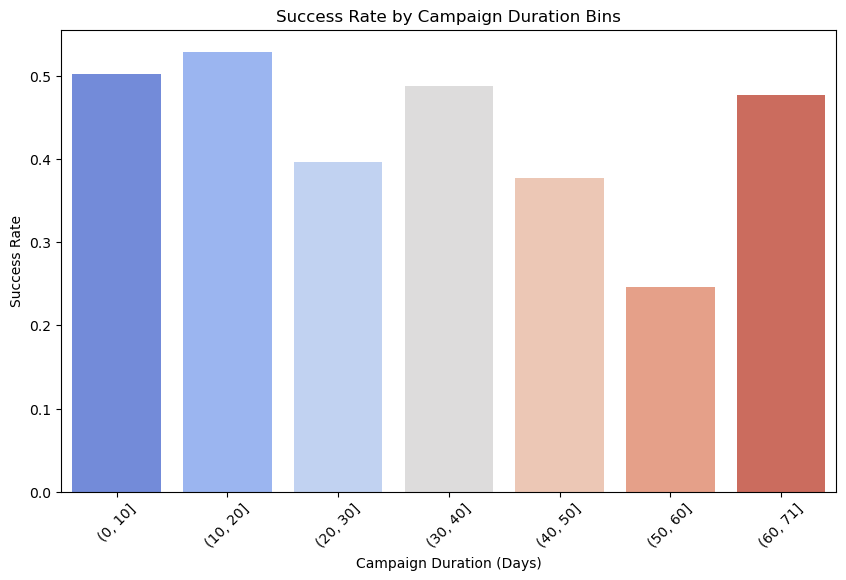

,Duration_Bins,Success_Rate
0,"(0, 10]",0.501689
1,"(10, 20]",0.528865
2,"(20, 30]",0.396357
3,"(30, 40]",0.487524
4,"(40, 50]",0.376670
5,"(50, 60]",0.246000
6,"(60, 71]",0.477419


In [25]:
# Binning the campaign duration into ranges for better analysis
duration['Duration_Bins'] = pd.cut(duration['Duration_of_campaign(days)'], bins=[0, 10, 20, 30, 40, 50, 60, duration['Duration_of_campaign(days)'].max()])

# Calculating success rates within each bin
success_rate_by_duration = duration.groupby('Duration_Bins').apply(lambda x: x[x['state'] == 'successful'].shape[0] / x.shape[0]).reset_index(name='Success_Rate')

# Plotting
plt.figure(figsize=(10, 6))
sb.barplot(data=success_rate_by_duration, x='Duration_Bins', y='Success_Rate', palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Success Rate by Campaign Duration Bins')
plt.xlabel('Campaign Duration (Days)')
plt.ylabel('Success Rate')
plt.show()

success_rate_by_duration


# Data Analysis 3: Backers(Numberical)

We cloned the data to focus on hypothesis 3, backers vs state

In [26]:
backers = startup_data

In [27]:
#Removing Outliers
z_backers = np.abs(stats.zscore(backers['backers']))
threshold = 3
outliers_backers = backers[z_duration > threshold]
backers = backers.drop(outliers_duration.index)

<Axes: xlabel='backers', ylabel='state'>

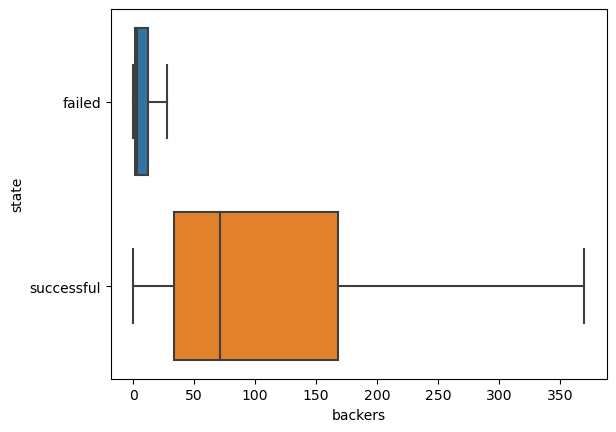

In [28]:
#In the following code, we plottted the box plot for backers vs state
sb.boxplot(data=backers, x="backers", y="state", showfliers = False)

In [29]:
print("Mean Number of Backers:")
print(backers.groupby('state')['backers'].mean())

print("\nMedian Number of Backers:")
print(backers.groupby('state')['backers'].median())


Mean Number of Backers:
state
failed         16.489126
successful    265.326972
Name: backers, dtype: float64

Median Number of Backers:
state
failed         3.0
successful    71.0
Name: backers, dtype: float64


The data is showing that the project would be more successful if there are more backers, which makes sense, now lets look at the success to see the correlation

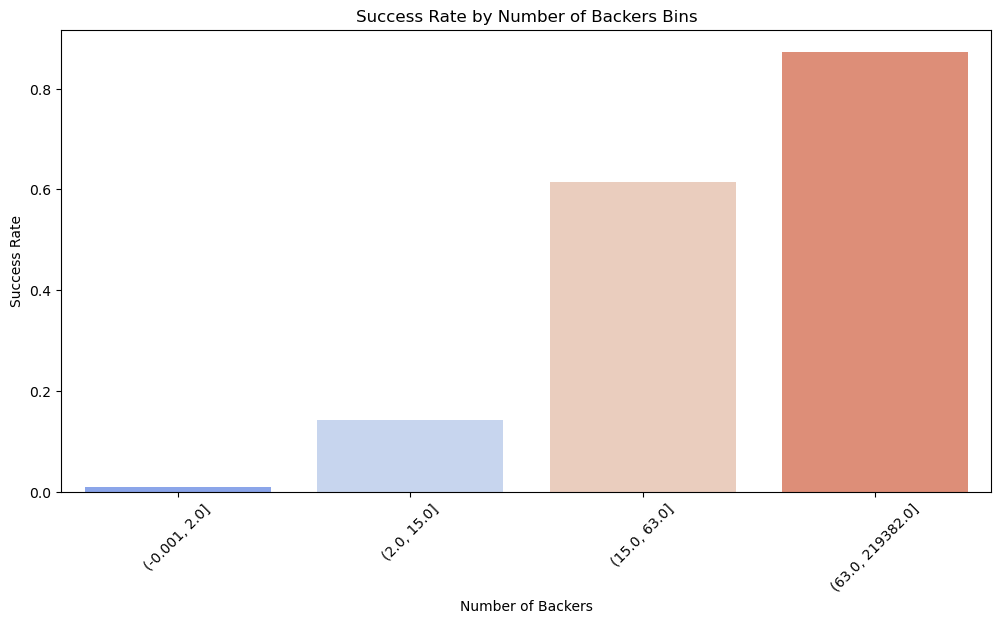

In [30]:
# Binning the number of backers into ranges for easier analysis
backers['Backers_Bins'] = pd.qcut(backers['backers'], q=4, duplicates='drop')  # Adjust 'q' based on distribution

# Calculating success rates within each bin
success_rate_by_backers = backers.groupby('Backers_Bins')['state'].apply(lambda x: (x == 'successful').mean()).reset_index(name='Success_Rate')

# Plotting
plt.figure(figsize=(12, 6))
sb.barplot(data=success_rate_by_backers, x='Backers_Bins', y='Success_Rate', palette='coolwarm')
plt.title('Success Rate by Number of Backers Bins')
plt.xlabel('Number of Backers')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.show()


# Data Analysis 4: Pledged Amount(Numberical)

We cloned the data to focus on hypothesis 4, pledge amount vs state

In [31]:
pledge = startup_data

In [32]:
z_pledge = np.abs(stats.zscore(backers['usd_pledged_real']))
threshold = 3
outliers_pledge = backers[z_pledge > threshold]
pledge = pledge.drop(outliers_duration.index)

<Axes: xlabel='usd_pledged_real', ylabel='state'>

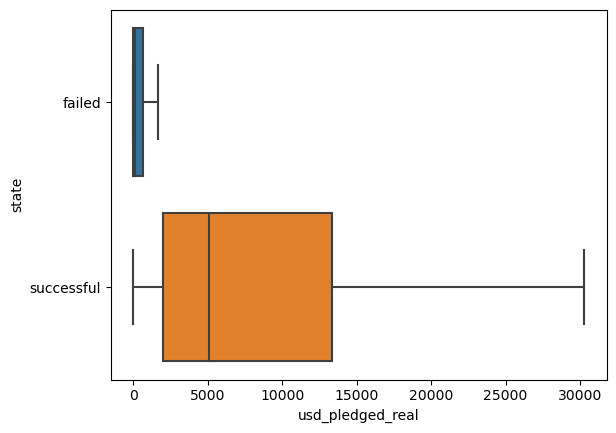

In [33]:
#In the following code, we plottted the box plot for backers vs state
sb.boxplot(data=pledge, x="usd_pledged_real", y="state", showfliers = False)

In [34]:
print("Mean Number of Backers:")
print(pledge.groupby('state')['usd_pledged_real'].mean())

print("\nMedian Number of Backers:")
print(pledge.groupby('state')['usd_pledged_real'].median())


Mean Number of Backers:
state
failed         1326.816298
successful    22790.375035
Name: usd_pledged_real, dtype: float64

Median Number of Backers:
state
failed         100.0
successful    5114.0
Name: usd_pledged_real, dtype: float64


Data over here is also showing that if there is a higher amount pledge, the project tend to be more successful. 

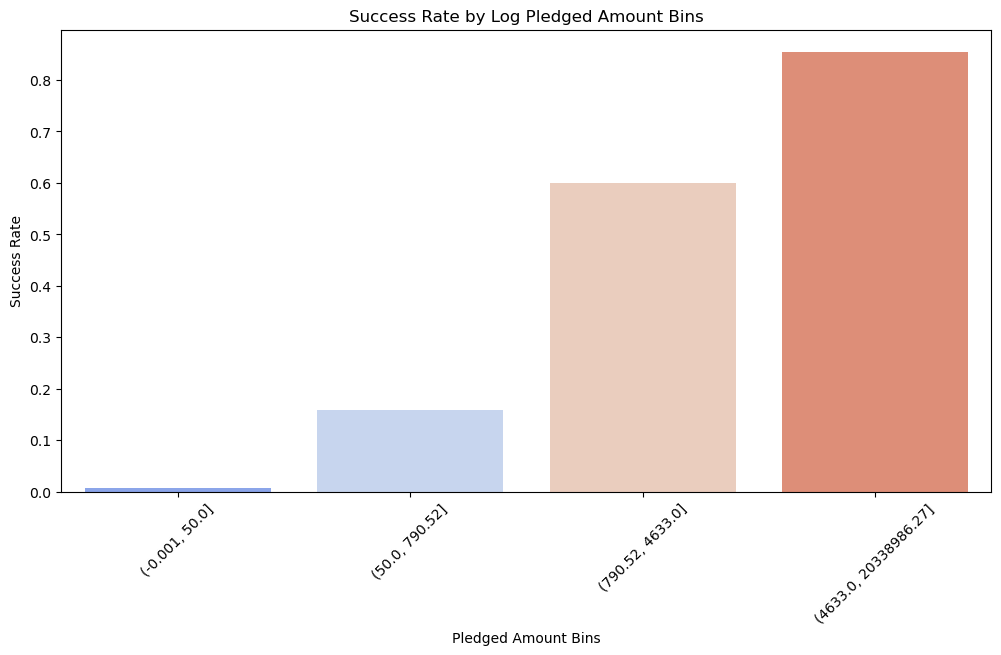

In [35]:
pledge['Pledged_Bins'] = pd.qcut(pledge['usd_pledged_real'], q=4, duplicates='drop')

success_rate_by_pledged = pledge.groupby('Pledged_Bins')['state'].apply(lambda x: (x == 'successful').mean()).reset_index(name='Success_Rate')

plt.figure(figsize=(12, 6))
sb.barplot(data=success_rate_by_pledged, x='Pledged_Bins', y='Success_Rate', palette='coolwarm')
plt.title('Success Rate by Log Pledged Amount Bins')
plt.xlabel('Pledged Amount Bins')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.show()


# Data Analysis 5: Categories(Categorical)

We cloned the data to focus on hypothesis 5, category vs state

In [36]:
category = startup_data

C:\Users\user\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


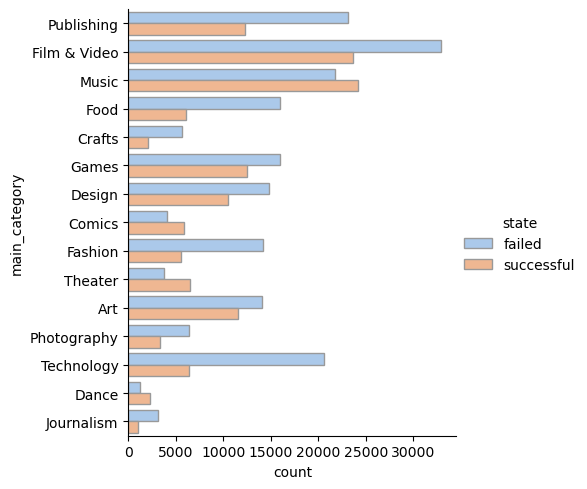

In [37]:
sb.catplot(data=category, y="main_category", hue="state", kind="count",palette="pastel", edgecolor=".6",)

# Data Analysis 6: Categories(Categorical)

We cloned the data to focus on hypothesis 6, country vs state

In [38]:
country = startup_data

C:\Users\user\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


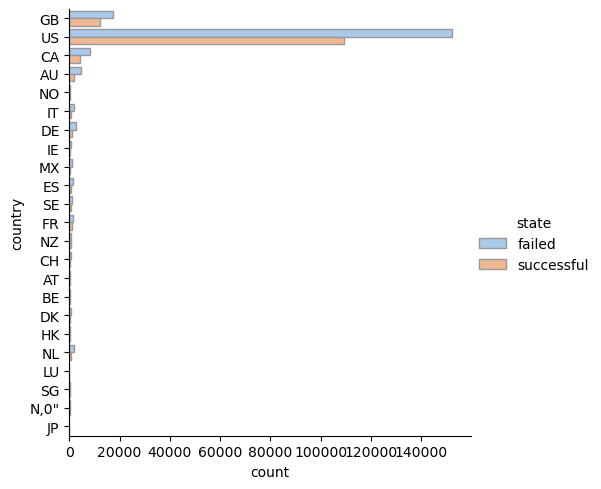

In [39]:
sb.catplot(data=country, y="country", hue="state", kind="count",palette="pastel", edgecolor=".6",)

We were able to form some insights from our initial exploratory analysis.
1) Successful kickstarters tend to have lower goal amounts
2) The 'sweet spot' duration for successful kickstarter is between 20 to 40 days
3) Successful kickstarters have more backers
4) Successful kickstarters were able to raise more money(duhhh)
5) Certain categories are more likely to be sucessful, like Theatre and Music
6) Most projects are based in GB, US, CA, AU, IT and DE and most countries seem to have similar rates of success for their projects

# Machine Learning
We will be creating a model to predict the success of a project based of several variables

In [40]:
#startup_data (original data)
startup_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 331675 entries, 0 to 378660
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   main_category               331675 non-null  object 
 1   state                       331675 non-null  object 
 2   backers                     331675 non-null  int64  
 3   country                     331675 non-null  object 
 4   usd_pledged_real            331675 non-null  float64
 5   usd_goal_real               331675 non-null  float64
 6   state_num                   331675 non-null  int32  
 7   encoded_country             331675 non-null  int32  
 8   encoded_main_category       331675 non-null  int32  
 9   Duration_of_campaign(days)  331675 non-null  int64  
 10  Deadline(y)                 331675 non-null  int32  
 11  Launched(y)                 331675 non-null  int32  
 12  Launched(m)                 331675 non-null  int32  
 13  Deadline(m)        

Variables we want to use in the models are fixed factors which that are determined from the beginning. This is because we want to predict whether a project will fail or suceed while it is still campaigning. Once it's over, there's no point predicting it since we can check it directly from the site (e.g. usd_goal_real).

Variables used in model,
1) main_category
2) usd_goal_real
3) ~country~
4) Duration_of_campaign(days)
5) State

In [41]:
model_data = startup_data[['main_category','Duration_of_campaign(days)','usd_goal_real', 'state']]

In [49]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
model_data_cat = model_data[['main_category']]
ohe.fit(model_data_cat)
model_data_cat_ohe = pd.DataFrame(ohe.transform(model_data_cat).toarray(), 
                                  columns=ohe.get_feature_names_out(model_data_cat.columns))
model_data_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331675 entries, 0 to 331674
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   main_category_Art           331675 non-null  float64
 1   main_category_Comics        331675 non-null  float64
 2   main_category_Crafts        331675 non-null  float64
 3   main_category_Dance         331675 non-null  float64
 4   main_category_Design        331675 non-null  float64
 5   main_category_Fashion       331675 non-null  float64
 6   main_category_Film & Video  331675 non-null  float64
 7   main_category_Food          331675 non-null  float64
 8   main_category_Games         331675 non-null  float64
 9   main_category_Journalism    331675 non-null  float64
 10  main_category_Music         331675 non-null  float64
 11  main_category_Photography   331675 non-null  float64
 12  main_category_Publishing    331675 non-null  float64
 13  main_category_

In [50]:
# Combining Numeric features with the OHE Categorical features
model_num = model_data[['Duration_of_campaign(days)','usd_goal_real']]
model_res = startup_data['state']
model_data_ohe = pd.concat([model_num, model_data_cat_ohe, model_res], 
                           sort = False, axis = 1).reindex(index=model_num.index)

# Check the final dataframe
model_data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 331675 entries, 0 to 378660
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Duration_of_campaign(days)  331675 non-null  float64
 1   usd_goal_real               331675 non-null  float64
 2   main_category_Art           290534 non-null  float64
 3   main_category_Comics        290534 non-null  float64
 4   main_category_Crafts        290534 non-null  float64
 5   main_category_Dance         290534 non-null  float64
 6   main_category_Design        290534 non-null  float64
 7   main_category_Fashion       290534 non-null  float64
 8   main_category_Film & Video  290534 non-null  float64
 9   main_category_Food          290534 non-null  float64
 10  main_category_Games         290534 non-null  float64
 11  main_category_Journalism    290534 non-null  float64
 12  main_category_Music         290534 non-null  float64
 13  main_category_Photo

[Text(0.375, 0.875, 'usd_goal_real <= 15031.0\ngini = 0.482\nsamples = 232172\nvalue = [138299, 93873]\nclass = successful'),
 Text(0.25, 0.625, 'gini = 0.489\nsamples = 176713\nvalue = [96131, 80582]\nclass = successful'),
 Text(0.5, 0.625, 'Duration_of_campaign(days) <= 29.5\ngini = 0.369\nsamples = 55459\nvalue = [42168, 13291]\nclass = successful'),
 Text(0.25, 0.375, 'usd_goal_real <= 40171.291\ngini = 0.361\nsamples = 30108\nvalue = [23304, 6804]\nclass = successful'),
 Text(0.125, 0.125, 'gini = 0.381\nsamples = 18526\nvalue = [13366, 5160]\nclass = successful'),
 Text(0.375, 0.125, 'gini = 0.243\nsamples = 11582\nvalue = [9938, 1644]\nclass = successful'),
 Text(0.75, 0.375, 'Duration_of_campaign(days) <= 47.5\ngini = 0.372\nsamples = 25351\nvalue = [18864, 6487]\nclass = successful'),
 Text(0.625, 0.125, 'gini = 0.42\nsamples = 16281\nvalue = [10842, 5439]\nclass = successful'),
 Text(0.875, 0.125, 'gini = 0.199\nsamples = 9070\nvalue = [8022, 1048]\nclass = successful')]

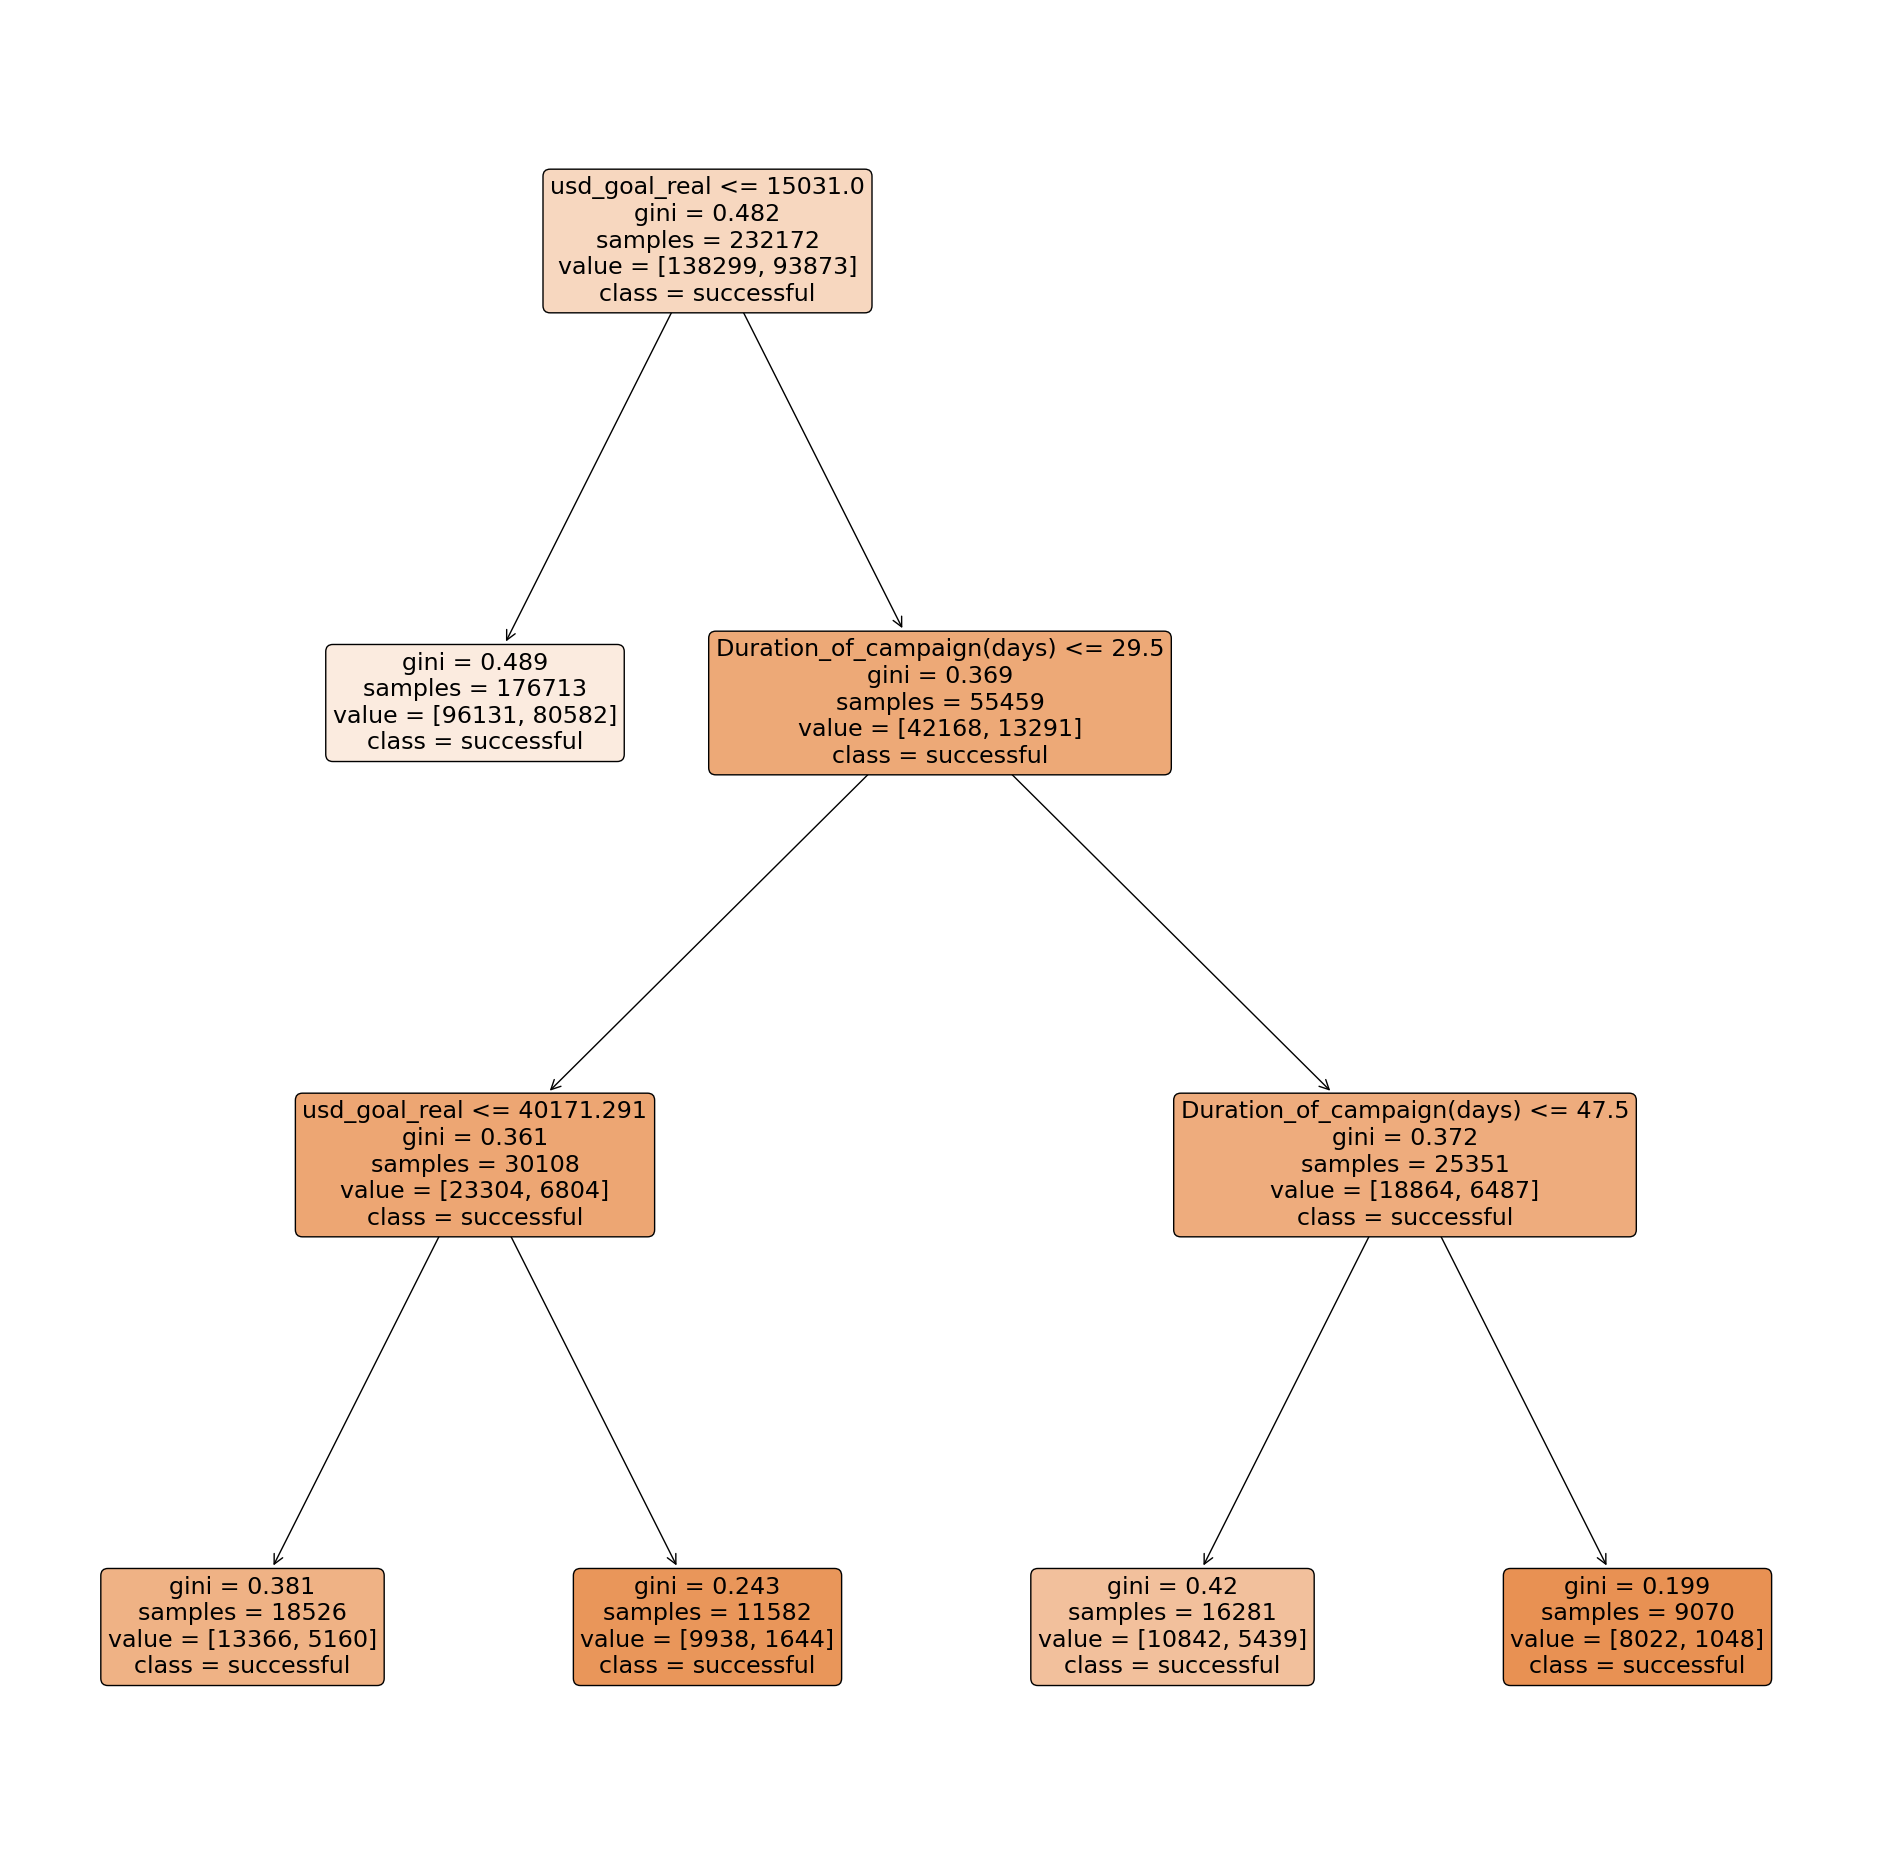

In [54]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

# Extract Response and Predictors
y = pd.DataFrame(model_data_ohe["state"])
X = pd.DataFrame(model_data_ohe.drop("state", axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 3)  # change max_depth to experiment
dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=list(X_train.columns), 
          class_names=["successful", "failed"]) #added list() to make it work

### Check the accuracy of the Model

Print the Classification Accuracy and all other Accuracy Measures from the Confusion Matrix.  

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 

Train Data
Accuracy  :	 0.5964117448423355

TPR Train :	 0.0
TNR Train :	 1.0

FPR Train :	 0.0
FNR Train :	 1.0


<Axes: >

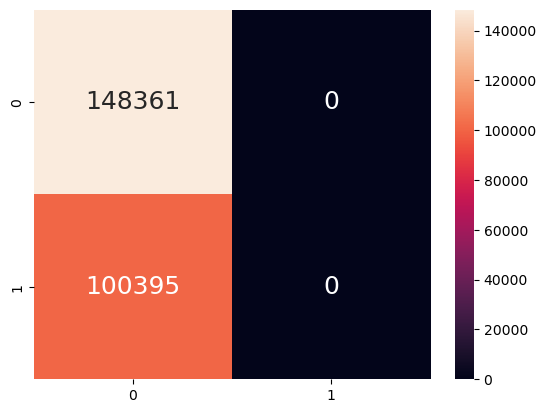

In [45]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.5952556108973818

TPR Test :	 0.0
TNR Test :	 1.0

FPR Test :	 0.0
FNR Test :	 1.0


<Axes: >

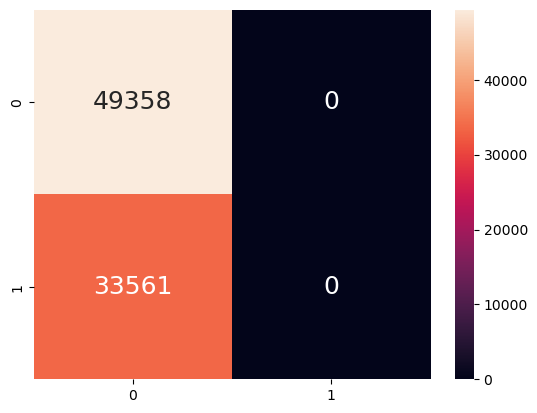

In [46]:
# Import the required metric from sklearn
from sklearn.metrics import confusion_matrix

# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})